# Fashion Victim Model

[![Binder](https://mybinder.org/badge_logo.svg)](https://mybinder.org/v2/gh/econ-ark/DemArk/master?filepath=notebooks%2Fhttps%3A%2F%2Fgithub.com%2Fecon-ark%2FDemARK%2Fblob%2Fmaster%2Fnotebooks%2Fhttps%3A%2F%2Fgithub.com%2Fecon-ark%2FDemARK%2Fblob%2Fmaster%2Fnotebooks%2Fhttps%3A%2F%2Fgithub.com%2Fecon-ark%2FDemARK%2Fblob%2Fmaster%2Fnotebooks%2FFashion-Victim-Model.ipynb)

Specifies a dynamic model of fashion selection in a world with only two styles:
jock and punk. Forward-looking agents receive utility from the style they choose
based on the proportion of the population with the same style (as well as direct
preferences each style), and pay switching costs if they change.

In [1]:
# This cell has just a bit of initial setup. You can click the triangle to the left to expand it.
# Click the "Run" button immediately above the notebook in order to execute the contents of any cell
# WARNING: Each cell in the notebook relies upon results generated by previous cells
#   The most common problem beginners have is to execute a cell before all its predecessors
#   If you do this, you can restart the kernel (see the "Kernel" menu above) and start over
%matplotlib inline
import matplotlib.pyplot as plt

# The first step is to be able to bring things in from different directories
import sys 
import os

sys.path.insert(0, os.path.abspath('../'))

import numpy as np
from time import clock
from copy import deepcopy

from HARK.core import AgentType, Solution, NullFunc
from HARK.interpolation import LinearInterp
from HARK.utilities import approxUniform, plotFuncs
import scipy.stats as stats
from copy import copy

## FashionVictimType

This module defines a subclass of AgentType called FashionVictimType.

In [2]:
from HARK.FashionVictim.FashionVictimModel import FashionVictimType

Each period, fashion victims make a binary choice of style $s$: to dress as a jock (0) or punk (1).  They receive utility directly from the outfit they wear and as a function of the proportion of the population who $\textit{just wore}$ the same style; they also pay switching costs ($c_{pj}$,$c_{jp}$) if they change styles rather than keep the same as the previous period.  Moreover, they receive an idiosyncratic type 1 extreme value (T1EV) preference shock to each style in each period.

Defining the population punk proportion as $p$ and the conformity utility function as $f:[0,1]\rightarrow \mathbb{R}$, the current period utility function is thus:

\begin{equation*}
u(s_t;s_{t-1},p_t) = s_t f(p_t) + (1-s_t) f(1-p_t) + s_t U_p + (1-s_t) U_j - c_{pj} s_{t-1}(1-s_t) - c_{jp}(1-s_{t-1})s_t.
\end{equation*}

Fashion victims are forward looking and discount future utility at a constant rate of $\beta$ per period.  To simplify the analysis, we assume they believe that the population punk proportion in the next period is a linear function of the punk proportion in the current period, subject to a uniformly distributed shock.  No restrictions are put on the function $f$; fashion victims might be conformists who like to dress the same as others ($f'(p) > 0$) or hipsters who like to style themselves in the minority ($f'(p) < 0$).

A fashion victim's problem can be written in Bellman form as:
\begin{equation*}
V(s_{t-1},p_t) = E \left[ \max_{s_t \in \{0,1\}} u(s_t;s_{t-1},p_t) + \eta_{s_t} + \beta E \left[ V(s_t,p_{t+1}) \right] \right], 
\end{equation*}

\begin{equation*}
p_{t+1} = a p_t + b + \pi_{t+1}, \qquad \pi_{t+1} \sim U[-w,w], \qquad \eta_0,\eta_1 \sim T1EV.
\end{equation*}

An instance of $\texttt{FashionVictimType}$ is thus characterized by values of $U_p$, $U_j$, $c_{pj}$, $c_{jp}$ and a function $f$, as well as beliefs about $p_{t+1}$ as a function of $p_t$ (summarized by slope $a$, intercept $b$, and uniform shock width $w$).  Given this information, a $\texttt{FashionVictimType}$'s infinite horizon microeconomic model can be solved by backward induction in a few lines; the "one period solver" is given by $\texttt{solveFashion}$.  However, while individual agents treat the dynamics of $p_t$ as exogenous, they are in fact endogenously determined by the actions of all the fashion victims in the market.  A dynamic general equilibrium of the "macroeconomic fashion model" is thus characterized by a triple of $(a,b,w)$ such that when fashion victims believe in this "punk evolution rule" and act optimally, their collective fashion choices exhibit this same rule when the model is simulated.



### Solving FashionVictimType's Micro Model

First we will define the parameters for test object which is an instance of FashionVictimType.

In [3]:
'''
Defines some default parameters for the fashion victim model.
'''

DiscFac          = 0.95   # Intertemporal discount factor
uParamA          = 1.0    # Parameter A in the utility function (pdf of the beta distribution)
uParamB          = 5.0    # Parameter B in the utility function (pdf of the beta distribution)
punk_utility     = 0.0    # Direct utility received from dressing as a punk
jock_utility     = 0.0    # Direct utility received from dressing as a jock
switchcost_J2P   = 2.0    # Cost of switching from jock to punk
switchcost_P2J   = 2.0    # Cost of switching from punk to jock
pCount           = 51     # Number of points in the grid of population punk proportion values
pref_shock_mag   = 0.5    # Scaling factor for the magnitude of transitory style preference shocks
pNextIntercept   = 0.1    # Intercept of linear function of beliefs over next period's punk proportion
pNextSlope       = 0.8    # Slope of linear function of beliefs over next period's punk proportion
pNextWidth       = 0.1    # Width of uniform distribution of next period's punk proportion (around linear function)
pNextCount       = 10     # Number of points in discrete approximation to distribution of next period's p
pop_size         = 20     # Number of fashion victims of this type (for simulation)
p_init           = 0.5    # Probability of being dressed as a punk when the simulation begins

# Make a dictionary for convenient type creation
default_params={'DiscFac'      : DiscFac,
               'uParamA'       : uParamA,
               'uParamB'       : uParamB,
               'punk_utility'  : punk_utility,
               'jock_utility'  : jock_utility,
               'switchcost_J2P': switchcost_J2P,
               'switchcost_P2J': switchcost_P2J,
               'pCount'        : pCount,
               'pref_shock_mag': pref_shock_mag,
               'pNextIntercept': pNextIntercept,
               'pNextSlope'    : pNextSlope,
               'pNextWidth'    : pNextWidth,
               'pNextCount'    : pNextCount,
               'pop_size'      : pop_size,
               'p_init'        : p_init
               }

Then we can create our test object via passing previously defined parameters.

Utility function:


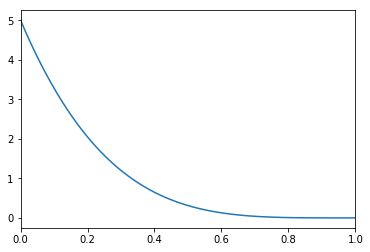

In [4]:
TestType = FashionVictimType(**default_params)
print('Utility function:')
plotFuncs(TestType.conformUtilityFunc,0,1)

To solve the TestType we can simply use solve method.

In [5]:
TestType.solve()

And here we can observe the solution from illustrations.

Jock value function:


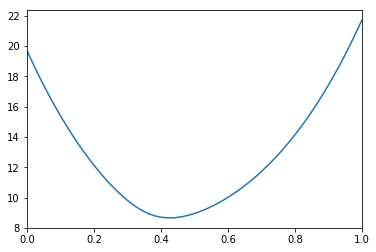

Punk value function:


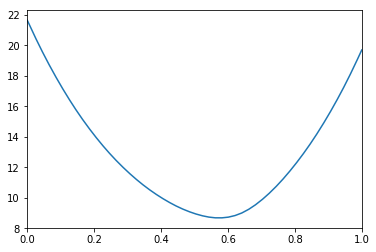

Jock switch probability:


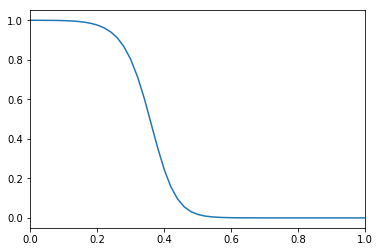

Punk switch probability:


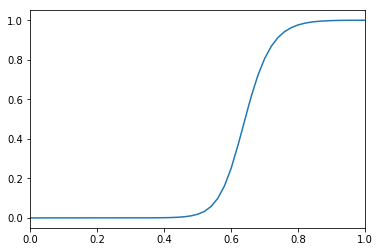

In [6]:
print('Jock value function:')
plotFuncs(TestType.VfuncJock,0,1)
print('Punk value function:')
plotFuncs(TestType.VfuncPunk,0,1)
print('Jock switch probability:')
plotFuncs(TestType.switchFuncJock,0,1)
print('Punk switch probability:')
plotFuncs(TestType.switchFuncPunk,0,1)

### Creating a list of different FashionVictimTypes

In order to illustrate the Market class solution of FashionVictimModel we will create a list of different FashionVictimTypes.

In [7]:
# Make a list of different types

do_many_types = True

AltType = deepcopy(TestType)
AltType(uParamA = uParamB, uParamB = uParamA, seed=20)
AltType.update()
AltType.solve()
type_list = [TestType,AltType]
u_vec = np.linspace(0.02,0.1,5)
if do_many_types:
    for j in range(u_vec.size):
        ThisType = deepcopy(TestType)
        ThisType(punk_utility=u_vec[j])
        ThisType.solve()
        type_list.append(ThisType)
        ThisType = deepcopy(AltType)
        ThisType(punk_utility=u_vec[j])
        ThisType.solve()
        type_list.append(ThisType)
    for j in range(u_vec.size):
        ThisType = deepcopy(TestType)
        ThisType(jock_utility=u_vec[j])
        ThisType.solve()
        type_list.append(ThisType)
        ThisType = deepcopy(AltType)
        ThisType(jock_utility=u_vec[j])
        ThisType.solve()
        type_list.append(ThisType)

## Market class illustration with FashionVictimModel

The search for a dynamic general equilibrium is implemented in HARK's $\texttt{Market}$ class with the following definitions:

In [8]:
from HARK import Market
from HARK.FashionVictim.FashionVictimModel import *

TestMarket = Market(agents        = type_list,
                    sow_vars      = ['pNow'],
                    reap_vars     = ['sNow'],
                    track_vars    = ['pNow'],
                    dyn_vars      = ['pNextIntercept','pNextSlope','pNextWidth'],
                    millRule      = calcPunkProp,
                    calcDynamics  = calcFashionEvoFunc,
                    act_T         = 1000,
                    tolerance     = 0.01)
TestMarket.pNow_init = 0.5

The $\texttt{agents}$ attribute has a list of 22 $\texttt{FashionVictimType}$s, which vary in their values of $U_p$ and $U_j$, and their $f$ functions.  The $\texttt{marketAction}$ method of $\texttt{FashionVictimType}$ simulates one period of the microeconomic model: each agent receives style preference shocks $\eta_0$ and $\eta_1$, sees the current proportion of punks $p_t$ (sown to them as $\texttt{pNow}$), and chooses which style to wear, storing it in the binary array $\texttt{sNow}$, an attribute of $\texttt{self}$.

The $\texttt{millRule}$ for this market is extremely simple: it flattens the list of binary arrays of individual style choices (gathered in the $\texttt{reap}$ step) and averages them into a new value of $p_t$, to be tracked as a history and $\texttt{sow}$n back to the $\texttt{agents}$ to begin the cycle again.  Once a history of 1000 values of $p_t$ has been generated with the $\texttt{makeHistory}$ method, we can calculate a new dynamic fashion rule with $\texttt{calcFashionEvoFunc}$ by regressing $p_t$ on $p_{t-1}$, approximating $w$ as twice the standard deviation of prediction errors. The new fashion rule is an instance of the simple $\text{FashionEvoFunc}$ class, whose only methods are inherited from $\texttt{HARKobject}$.

When the $\texttt{solve}$ method is run, the solver successively solves each agent's microeconomic problem, runs the $\texttt{makeHistory}$ method to generate a 1000 period history of $p_t$, and calculates a new punk evolution rule based on this history; the solver terminates when consecutive rules differ by less than 0.01 in any dimension.


In [ ]:
TestMarket.solve()
plt.plot(TestMarket.pNow_hist)
plt.show()

**** WARNING: could not execute multiThreadCommands in HARK.core.Market.solveAgents()  so using the serial version instead. This will likely be slower. The multiTreadCommands() functions failed with the following error: 
 <class 'AttributeError'> : Can't pickle local object 'FashionVictimType.update.<locals>.<lambda>'
0.04893593293339532, 0.9005414551607436, 0.012243114740746353
0.09235533086634756, 0.813306906876119, 0.011962938869738713
0.055365685737197634, 0.88941863954236, 0.007402845496549826
0.0807008154796563, 0.8375977202286385, 0.011023488070380874
0.05474767615269688, 0.8913037394272025, 0.00953356057440743
0.08992523047026846, 0.8197352655506697, 0.009696418991967175
0.06313485433778243, 0.8730778229434656, 0.007648012727073658
0.08488337543454344, 0.829616388500038, 0.009070975601081527
